In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.load("../data/processed/X.npy")
y = np.load("../data/processed/y.npy")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((5634, 429), (1409, 429))

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

logreg = LogisticRegression(max_iter=3000, n_jobs=-1)
logreg.fit(X_train, y_train)

p_lr = logreg.predict_proba(X_test)[:, 1]

print("LogReg ROC-AUC:", roc_auc_score(y_test, p_lr))
print("LogReg PR-AUC :", average_precision_score(y_test, p_lr))


/mnt/c/users/efazh/Projects/multimodal-risk-detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


LogReg ROC-AUC: 0.8464116872045261
LogReg PR-AUC : 0.6499829582540316


/mnt/c/users/efazh/Projects/multimodal-risk-detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 3000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=3000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [3]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train, y_train)

p_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGB ROC-AUC:", roc_auc_score(y_test, p_xgb))
print("XGB PR-AUC :", average_precision_score(y_test, p_xgb))


XGB ROC-AUC: 0.8324226923971169
XGB PR-AUC : 0.6251572581549705


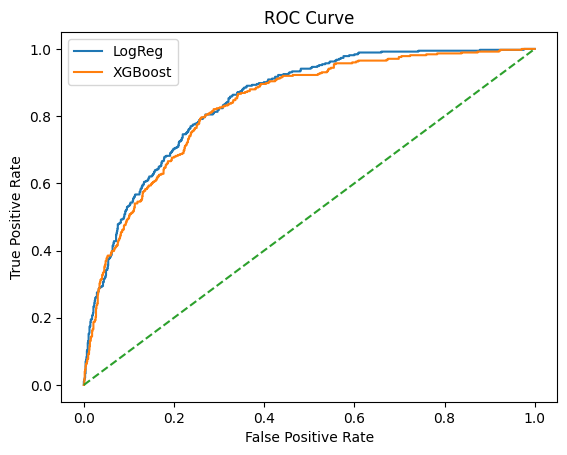

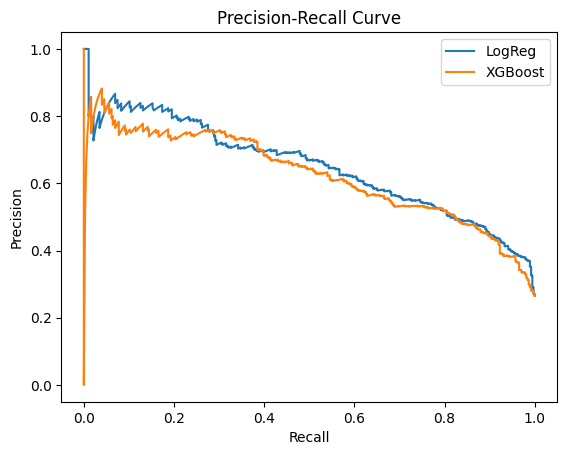

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, p_lr)
fpr_x, tpr_x, _ = roc_curve(y_test, p_xgb)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label="LogReg")
plt.plot(fpr_x, tpr_x, label="XGBoost")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, p_lr)
prec_x, rec_x, _ = precision_recall_curve(y_test, p_xgb)

plt.figure()
plt.plot(rec_lr, prec_lr, label="LogReg")
plt.plot(rec_x, prec_x, label="XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.842     0.902     0.871      1035
           1      0.663     0.532     0.591       374

    accuracy                          0.804      1409
   macro avg      0.753     0.717     0.731      1409
weighted avg      0.795     0.804     0.797      1409



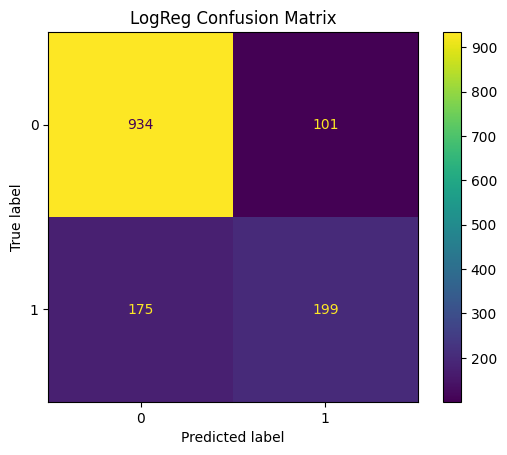

=== XGBoost ===
              precision    recall  f1-score   support

           0      0.842     0.883     0.862      1035
           1      0.625     0.540     0.580       374

    accuracy                          0.792      1409
   macro avg      0.734     0.712     0.721      1409
weighted avg      0.784     0.792     0.787      1409



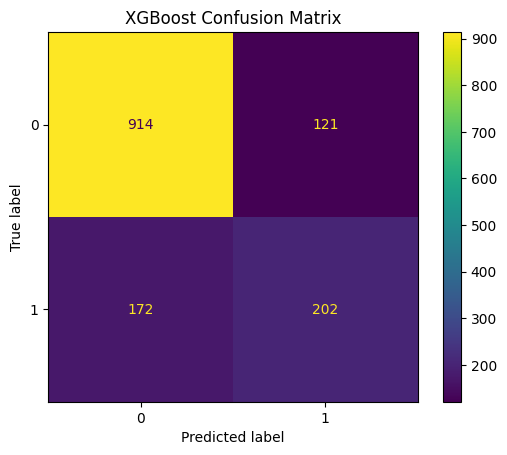

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

threshold = 0.5

yhat_lr = (p_lr >= threshold).astype(int)
yhat_xgb = (p_xgb >= threshold).astype(int)

print("=== Logistic Regression ===")
print(classification_report(y_test, yhat_lr, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_lr)).plot()
plt.title("LogReg Confusion Matrix")
plt.show()

print("=== XGBoost ===")
print(classification_report(y_test, yhat_xgb, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_test, yhat_xgb)).plot()
plt.title("XGBoost Confusion Matrix")
plt.show()


In [6]:
import joblib, os

os.makedirs("../models", exist_ok=True)
joblib.dump(logreg, "../models/model_logreg.joblib")
joblib.dump(xgb, "../models/model_xgb.joblib")
print("Saved models to ../models/")


Saved models to ../models/
